In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Mounting Google Drive to access Dataset
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 1. LOAD DATA
tp = pd.read_csv('/content/drive/MyDrive/trustpilot_all_reviews.csv', parse_dates=['date'], dayfirst=True)
ps = pd.read_csv('/content/drive/MyDrive/playstore_all_reviews.csv', parse_dates=['date'])

/tmp/ipython-input-1665188115.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  tp = pd.read_csv('/content/drive/MyDrive/trustpilot_all_reviews.csv', parse_dates=['date'], dayfirst=True)


In [4]:

# 3. Helper functions
def clean_text(text):
    """Lowercase, remove punctuation, stopwords."""
    tokens = nltk.word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    return ' '.join(tokens)

def add_sentiment(df, text_col='review_text'):
    """Compute polarity and subjectivity via TextBlob."""
    df['clean_text'] = df[text_col].fillna('').apply(clean_text)
    df['polarity']   = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

def plot_rating_distribution(df, rating_col='rating', title='Rating Distribution'):
    sns.countplot(x=rating_col, data=df, palette='crest')
    plt.title(title)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

def plot_time_series(df, date_col='date', title='Reviews Over Time'):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    ts = df.set_index(date_col).resample('M').size()
    plt.figure(figsize=(10,4))
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.show()

def show_wordcloud(df, text_col='clean_text', title='Word Cloud'):
    text = ' '.join(df[text_col].dropna())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


In [5]:
tp = pd.DataFrame(tp)
ps = pd.DataFrame(ps)

In [6]:
tp.head()

,platform,rating,title,text,date,author,location
0,Deliveroo,1,Absolute Disaster-Read Review if you need a laugh,Today I ordered a delivery from M&S and it was...,2025-10-16,Suzanne,NaN
1,Deliveroo,1,awful experience,"awful experience, they were 90mins late with ...",2025-10-10,Toni Rodel,NaN
2,Deliveroo,1,The worst customer support,An order was advertised as 20-30 mins delivery...,2025-10-06,Trevor,NaN
3,Deliveroo,1,No help! Very disappointing customer service! ...,I ordered of deliveroo and I just got false ad...,2025-09-24,Amy,NaN
4,Deliveroo,1,Just an appalling company,Just an appalling company. O e of their driver...,2025-09-23,Gearoid Cotter,NaN


In [7]:
# 5. Trustpilot EDA
print("=== Trustpilot Data ===")
print(tp.info())
print(tp.describe(include='all'))

=== Trustpilot Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   platform  600 non-null    object        
 1   rating    600 non-null    int64         
 2   title     600 non-null    object        
 3   text      587 non-null    object        
 4   date      600 non-null    datetime64[ns]
 5   author    600 non-null    object        
 6   location  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 32.9+ KB
None
         platform      rating          title  \
count         600  600.000000            600   
unique          3         NaN            583   
top     Deliveroo         NaN  Great service   
freq          200         NaN              4   
mean          NaN    1.660000            NaN   
min           NaN    1.000000            NaN   
25%           NaN    1.000000      

/tmp/ipython-input-698799054.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=rating_col, data=df, palette='crest')


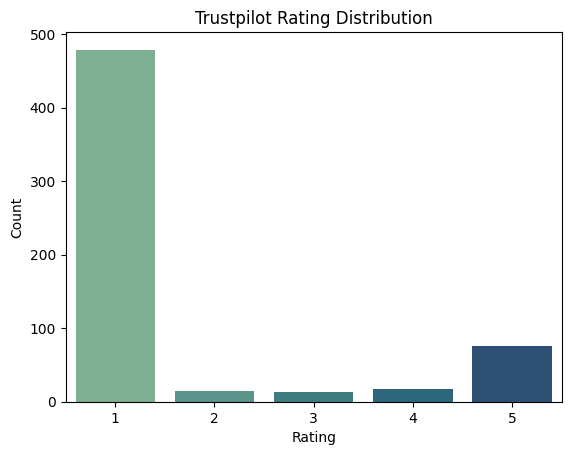

In [11]:
# 5.1 Rating distribution
plot_rating_distribution(tp, rating_col='rating', title='Trustpilot Rating Distribution')

/tmp/ipython-input-698799054.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index(date_col).resample('M').size()


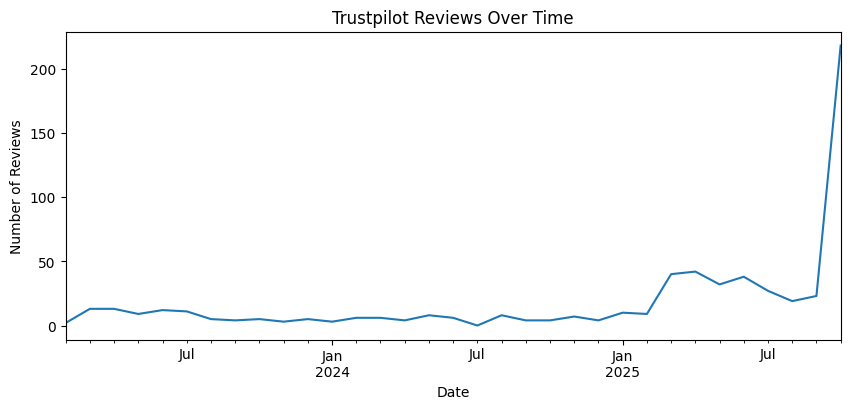

In [12]:
# 5.2 Time series of review volume
plot_time_series(tp, date_col='date', title='Trustpilot Reviews Over Time')

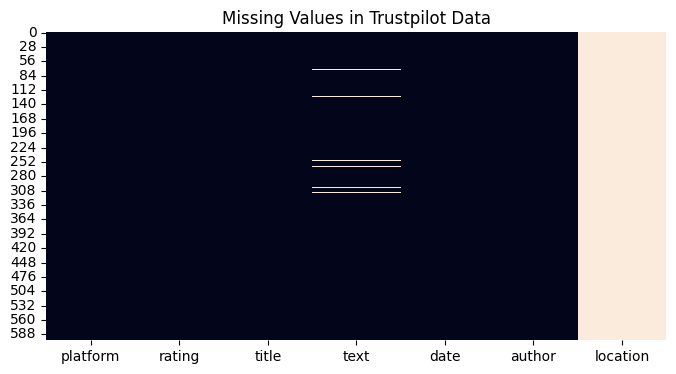

In [13]:
# 5.3 Missing values heatmap
plt.figure(figsize=(8,4))
sns.heatmap(tp.isnull(), cbar=False)
plt.title('Missing Values in Trustpilot Data')
plt.show()

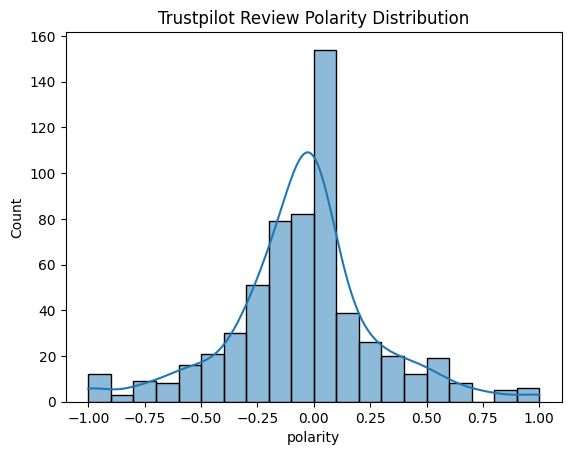

In [16]:
# 5.4 Sentiment analysis
tp = add_sentiment(tp, text_col='text')
sns.histplot(tp['polarity'], bins=20, kde=True)
plt.title('Trustpilot Review Polarity Distribution')
plt.show()

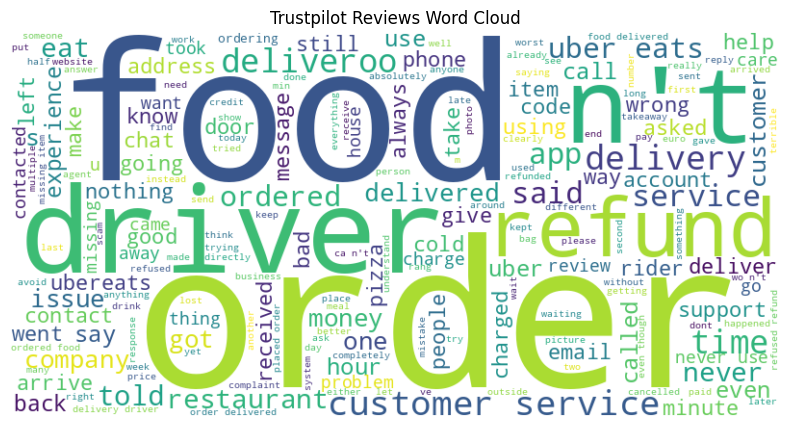

In [17]:
# 5.5 Word cloud of Trustpilot reviews
show_wordcloud(tp, text_col='clean_text', title='Trustpilot Reviews Word Cloud')

In [18]:
ps.head()

,platform,rating,text,date,thumbsUp,reviewer
0,Deliveroo,5,Deliveroo brighton amazing always brings my na...,2025-10-18 09:02:29,0,Revolver TG
1,Deliveroo,1,Worst customer service and delivery.,2025-10-18 07:23:54,0,George Ohanis
2,Deliveroo,1,Terrible customer service! no matter how wrong...,2025-10-18 05:39:32,0,Al-Anoud
3,Deliveroo,1,Uninstalled. My phone just notified me that de...,2025-10-18 05:02:15,0,Adam Gibbons
4,Deliveroo,1,Worst delivery My delivery was sitting in rest...,2025-10-18 03:16:51,0,Natalia T


In [19]:
# 6. Play Store EDA
print("=== Play Store Data ===")
print(ps.info())
print(ps.describe(include='all'))

=== Play Store Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   platform  1500 non-null   object        
 1   rating    1500 non-null   int64         
 2   text      1500 non-null   object        
 3   date      1500 non-null   datetime64[ns]
 4   thumbsUp  1500 non-null   int64         
 5   reviewer  1500 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 70.4+ KB
None
         platform       rating  text                           date  \
count        1500  1500.000000  1500                           1500   
unique          3          NaN  1419                            NaN   
top     Deliveroo          NaN  good                            NaN   
freq          500          NaN    19                            NaN   
mean          NaN     2.886000   NaN  2025-07-13 07:09:32.523333376   
m

/tmp/ipython-input-698799054.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=rating_col, data=df, palette='crest')


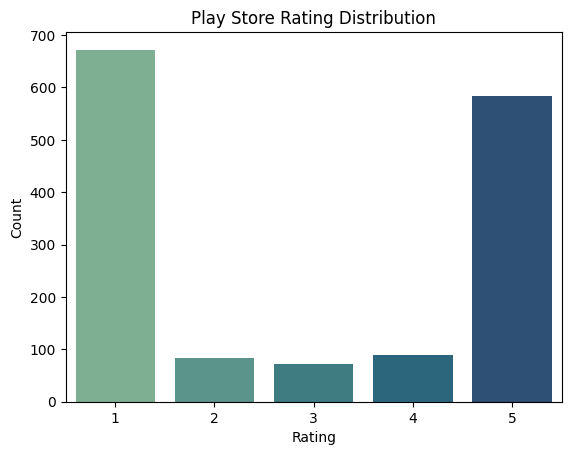

In [20]:
# 6.1 Rating distribution
plot_rating_distribution(ps, rating_col='rating', title='Play Store Rating Distribution')

/tmp/ipython-input-698799054.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index(date_col).resample('M').size()


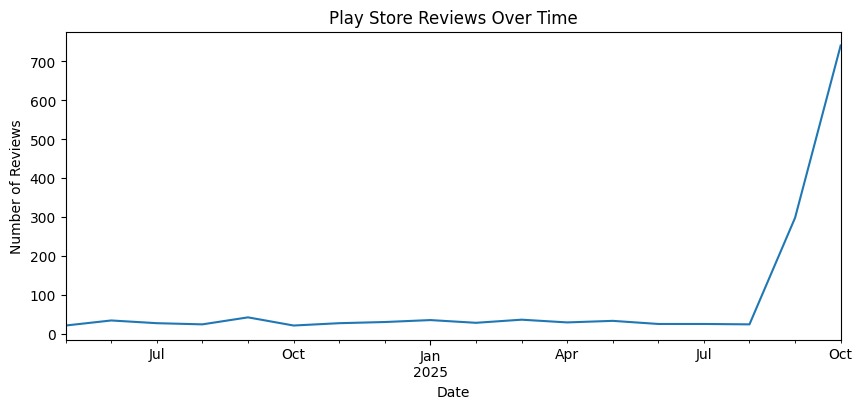

In [21]:
# 6.2 Time series of review volume
plot_time_series(ps, date_col='date', title='Play Store Reviews Over Time')

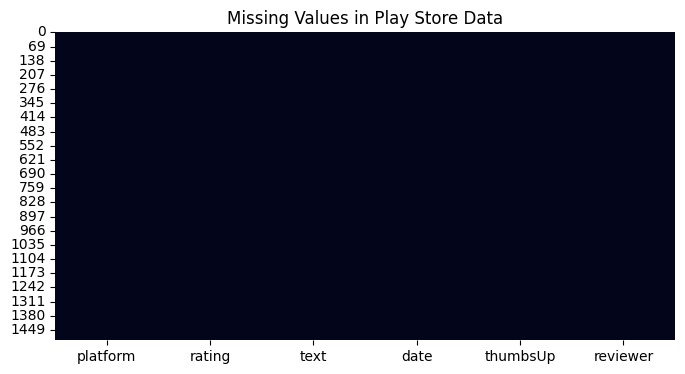

In [22]:
# 6.3 Missing values heatmap
plt.figure(figsize=(8,4))
sns.heatmap(ps.isnull(), cbar=False)
plt.title('Missing Values in Play Store Data')
plt.show()

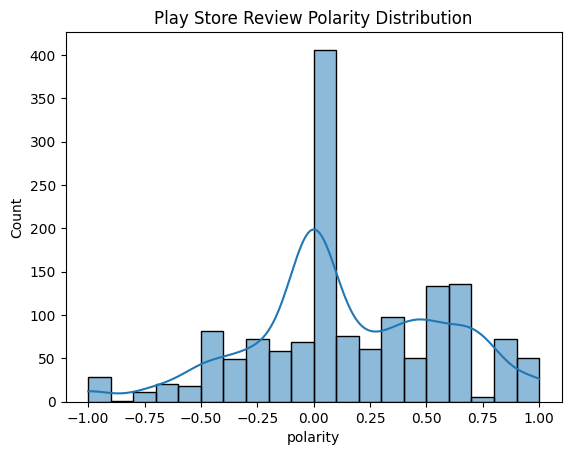

In [23]:

# 6.4 Sentiment analysis
ps = add_sentiment(ps, text_col='text')
sns.histplot(ps['polarity'], bins=20, kde=True)
plt.title('Play Store Review Polarity Distribution')
plt.show()

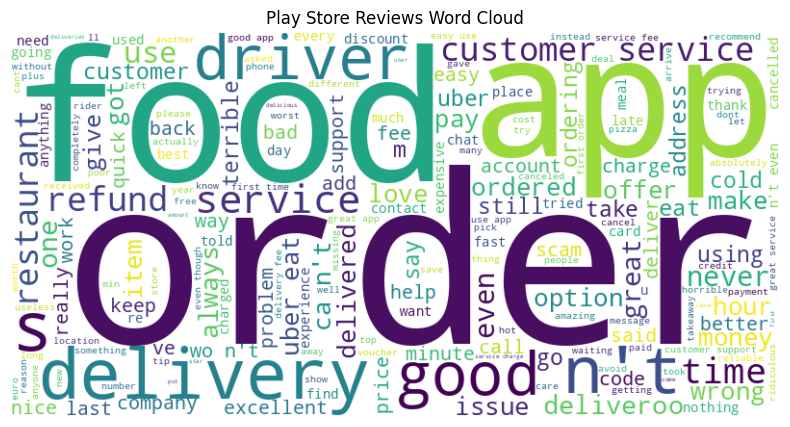

In [24]:
# 6.5 Word cloud of Play Store reviews
show_wordcloud(ps, text_col='clean_text', title='Play Store Reviews Word Cloud')

In [25]:
# 5.3 Trends over time (monthly)
tp_monthly = tp.set_index('date').resample('M').size().rename('count').reset_index()
ps_monthly = ps.set_index('date').resample('M').size().rename('count').reset_index()

fig = px.line(tp_monthly, x='date', y='count', title='Trustpilot Reviews Over Time')
fig.show()
fig = px.line(ps_monthly, x='date', y='count', title='PlayStore Reviews Over Time')
fig.show()

/tmp/ipython-input-2505533632.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tp_monthly = tp.set_index('date').resample('M').size().rename('count').reset_index()
/tmp/ipython-input-2505533632.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ps_monthly = ps.set_index('date').resample('M').size().rename('count').reset_index()


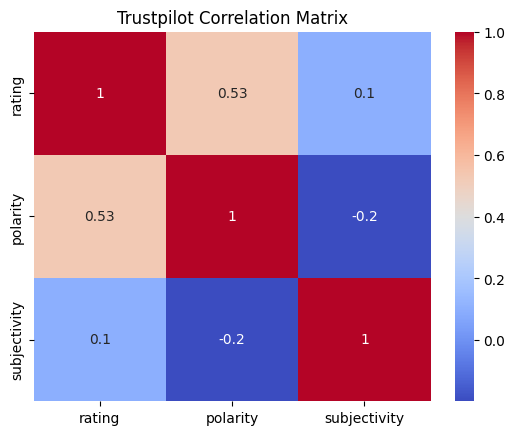

In [28]:
tp = add_sentiment(tp, 'text')
ps = add_sentiment(ps, 'text')

sns.heatmap(tp[['rating','polarity','subjectivity']].corr(), annot=True, cmap='coolwarm')
plt.title('Trustpilot Correlation Matrix')
plt.show()

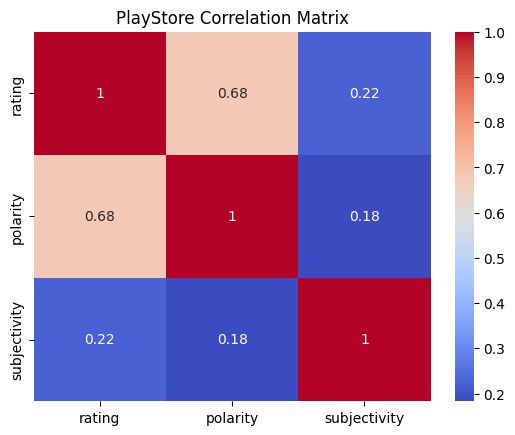

In [29]:
sns.heatmap(ps[['rating','polarity','subjectivity']].corr(), annot=True, cmap='coolwarm')
plt.title('PlayStore Correlation Matrix')
plt.show()

/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




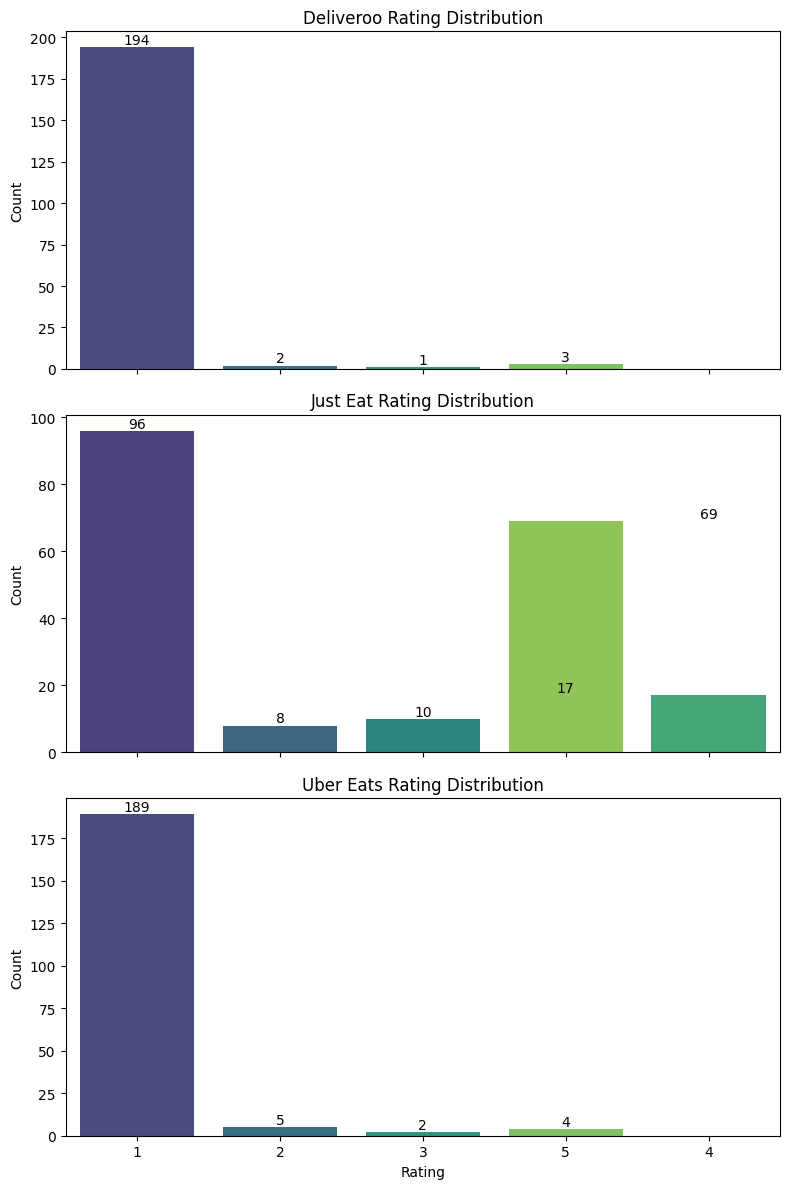

In [31]:
def plot_rating_distribution_separate(df, rating_col='rating', platform_col='platform'):
    """
    Plot separate bar charts of rating distribution for each platform.
    """
    platforms = df[platform_col].unique()
    n = len(platforms)
    fig, axes = plt.subplots(n, 1, figsize=(8, 4*n), sharex=True)

    if n == 1:
        axes = [axes]

    for ax, platform in zip(axes, platforms):
        subset = df[df[platform_col] == platform]
        counts = subset[rating_col].value_counts().sort_index()
        sns.barplot(x=counts.index, y=counts.values, palette="viridis", ax=ax)
        ax.set_title(f'{platform} Rating Distribution')
        ax.set_xlabel('Rating')
        ax.set_ylabel('Count')

        # Annotate counts on bars
        for i, v in enumerate(counts.values):
            ax.text(i, v + max(counts.values)*0.01, str(v), ha='center')

    plt.tight_layout()
    plt.show()



/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




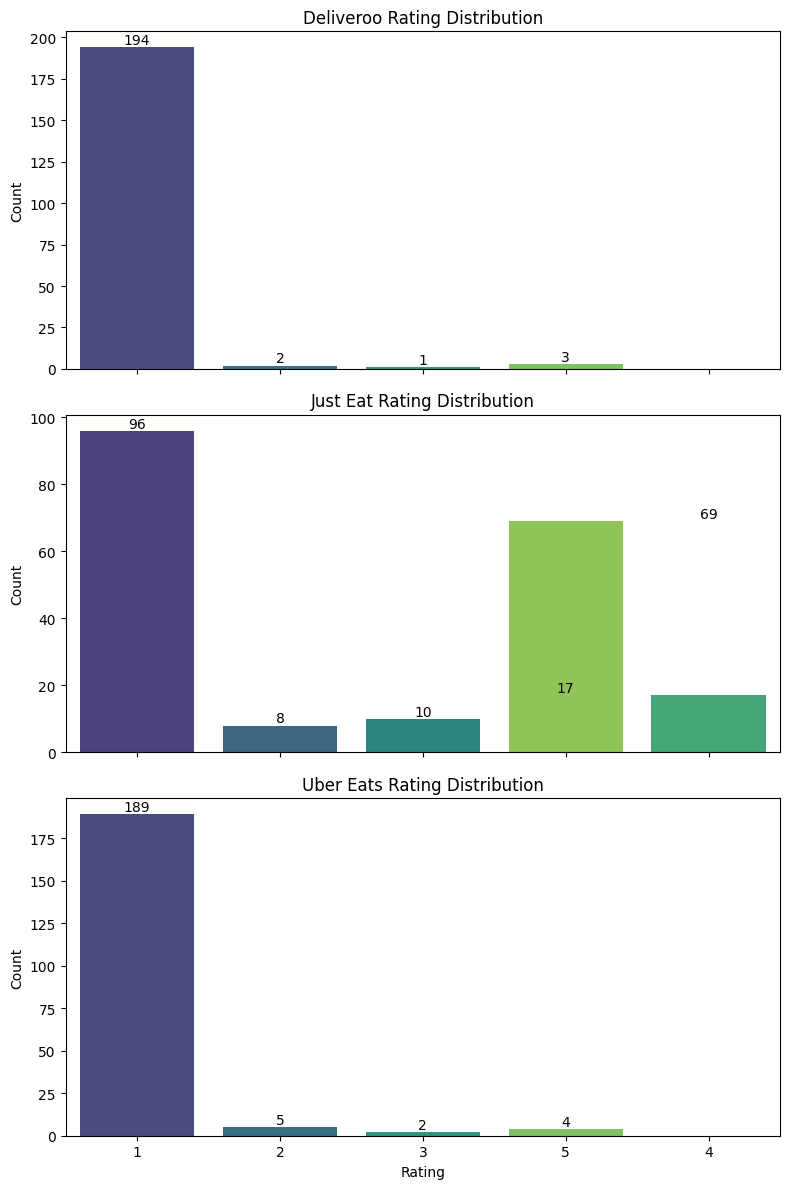

In [33]:
plot_rating_distribution_separate(tp, rating_col='rating', platform_col='platform')

/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2406874948.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




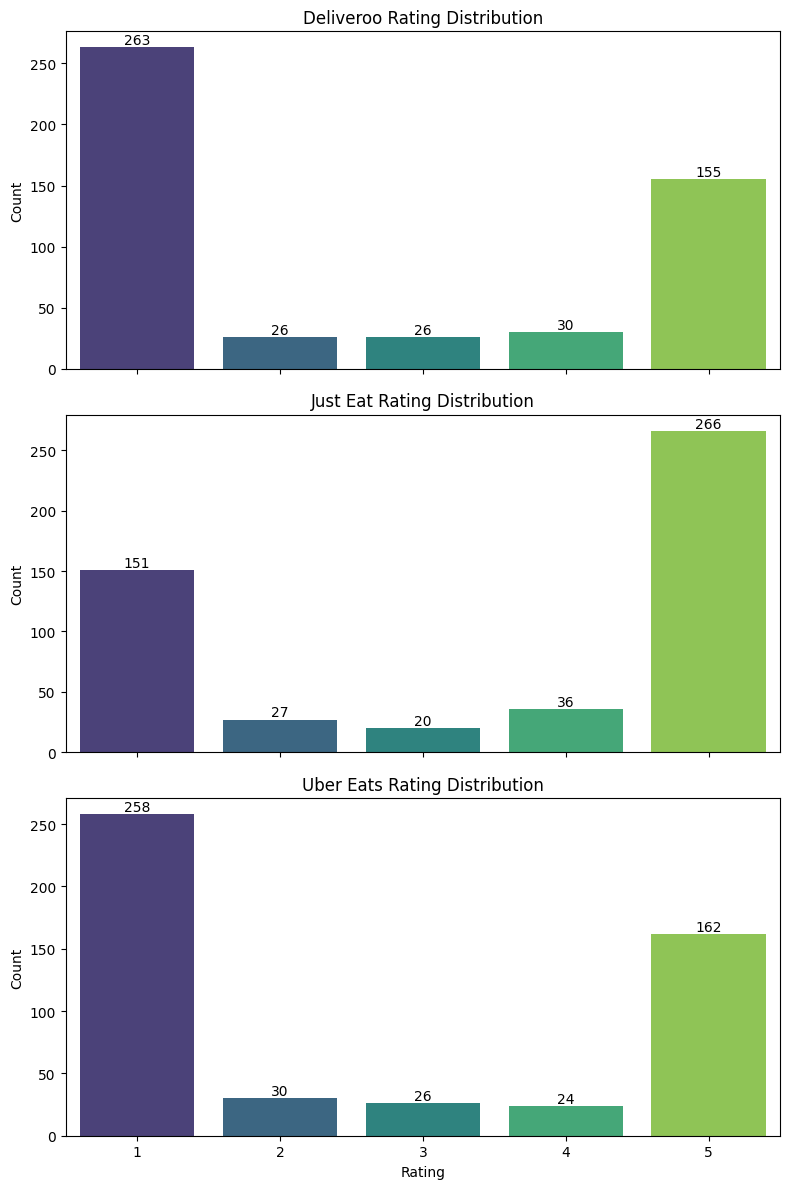

In [34]:
plot_rating_distribution_separate(ps, rating_col='rating', platform_col='platform')